In [8]:
import pandas
import numpy

In [9]:
fsi = pandas.read_csv("data/fragilestatesindex_joined.csv")
psq_tms_clean = pandas.read_csv("data/PSQ_TMS_filtered.csv")
gdp_clean = pandas.read_csv("data/world_bank_gdp/GDP_filtered.csv")
finance_data = pandas.read_csv("data/financial_data.csv")

In [10]:
finance_data_filtered = finance_data[["Country", "WEO Subject Code"] +[str(x) for x in range(2000, 2014)]]
finance_data_filtered.replace("n/a", numpy.nan, inplace=True)
finance_data_filtered = finance_data_filtered[finance_data["WEO Subject Code"] == "NGDPD"]
finance_data_filtered.drop("WEO Subject Code", axis=1, inplace=True)
finance_data_filtered.rename(columns={str(col): "GDP (Billions of USD), " + str(col) for col in range(2000, 2014)}, inplace=True)
finance_data_filtered.rename(columns={"Country": "Country Name"}, inplace=True)

/Users/steveellison/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [11]:
joined_data = pandas.merge(psq_tms_clean[["2013", "Country Name"]], fsi, on="Country Name")
joined_data = pandas.merge(joined_data, finance_data_filtered, on="Country Name")
joined_data.rename(columns={"2013" : "Total Refugee Count, 2013"}, inplace=True)
joined_data = joined_data.applymap(lambda x: str(x).replace(",",""))

In [12]:
columns_of_interest = ["Total Refugee Count, 2013"] + ["GDP (Billions of USD), %d" % x for x in range(2000,2014)] + \
                      ["Total %d" % x for x in range(2006,2015)]

In [13]:
joined_data_filtered = joined_data[columns_of_interest]
np_joined = joined_data_filtered.as_matrix().astype("float64")
np_joined = np_joined[~numpy.isnan(np_joined).any(axis=1)]
np_joined[:,0] = np_joined[:,0] / 1000.

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn import covariance

In [15]:
target = np_joined[:,0]
features = np_joined[:,1:]

features_normed = normalize(features, axis=0)

ftrain, ftest, ttrain, ttest = train_test_split(features, target, test_size=0.3, random_state=41234)
ntrain, ntest = train_test_split(features_normed, test_size=0.3, random_state = 41234)
linear_svr = LinearSVR(loss='epsilon_insensitive', epsilon=0, random_state = 12345)

linear_svr.fit(ntrain, ttrain)
preds_normed = linear_svr.predict(ntest)
print numpy.sqrt(metrics.mean_squared_error(ttest, preds_normed))
print metrics.r2_score(ttest, preds_normed)

249.773835775
-0.27197246054


In [16]:
num_models = range(50,300,5)
rmses_ada = []

for n in num_models:
    adaboost = AdaBoostRegressor(n_estimators = n, random_state = 12345)
    adaboost.fit(ntrain, ttrain)
    preds_adaboost = adaboost.predict(ntest)
    rmses_ada.append(numpy.sqrt(metrics.mean_squared_error(ttest, preds_adaboost)))

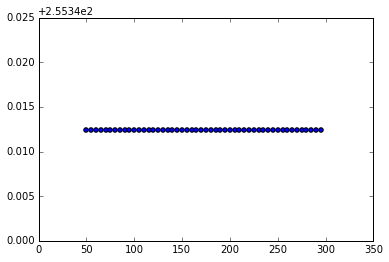

In [17]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(num_models, rmses_ada)

In [18]:
adaboost = AdaBoostRegressor(n_estimators = 105, random_state = 12345)

adaboost.fit(ntrain, ttrain)
preds_ada= adaboost.predict(ntest)
print numpy.sqrt(metrics.mean_squared_error(ttest, preds_ada))
print metrics.r2_score(ttest, preds_ada)

255.352383074
-0.329424420996


In [19]:
num_models = range(100,300,5)
rmses_gbt = []

for n in num_models:
    gbt = GradientBoostingRegressor(n_estimators = n, random_state = 12345)
    gbt.fit(ntrain, ttrain)
    preds_gbt = gbt.predict(ntest)
    rmses_gbt.append(numpy.sqrt(metrics.mean_squared_error(ttest, preds_gbt)))

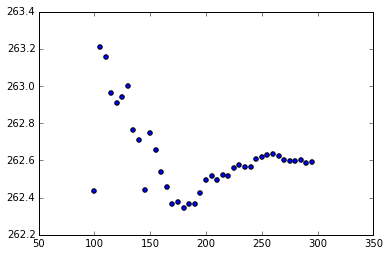

In [20]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.scatter(num_models, rmses_gbt)

In [21]:
gbt = GradientBoostingRegressor(n_estimators = 160, random_state = 12345)
gbt.fit(ntrain, ttrain)
preds_gbt = gbt.predict(ntest)

print numpy.sqrt(metrics.mean_squared_error(ttest, preds_gbt))
print metrics.r2_score(ttest, preds_gbt)

262.53622098
-0.40527810898


In [35]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split 

ftrain, ftest, ttrain, ttest = train_test_split(features, target, test_size=0.3, random_state=41234)
ntrain, ntest = train_test_split(features_normed, test_size=0.3, random_state = 41234)

from sklearn import linear_model
penaltyM = ["l2", "l1", "elasticnet"];
lossM = ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_loss", "huber", "epsilon_insensitive",
         "squared_epsilon_insensitive"];

sgdc_res = d3 = [[[0 for col in range(len(penaltyM))]for row in range(len(lossM))] for x in range(2)]

for i in range(len(penaltyM)):
    for j in range(len(lossM)):       
        sgd = linear_model.SGDClassifier(learning_rate='constant', n_jobs=3, eta0=.01, loss=lossM[j], n_iter=30, penalty=penaltyM[i], alpha=0.001)
        sgd.fit(ntrain, ttrain)
        prediction = sgd.predict(ntest)
        sgdc_res[i][j][0] = numpy.sqrt(metrics.mean_squared_error(ttest, prediction));
        sgdc_res[i][j][1] = metrics.r2_score(ttest, prediction);
        print penaltyM[i] + " " + lossM[j] + " " + sgdc_res[i][j][0] + " " + lossM[j];

               
               
    
    

ValueError: Unknown label type: array([  8.00000000e-03,   2.80000000e-02,   3.70000000e-02,
         1.32000000e-01,   1.38000000e-01,   2.91000000e-01,
         1.05600000e+00,   2.49600000e+00,   2.85200000e+00,
         3.09400000e+00,   3.23000000e+00,   3.99500000e+00,
         4.16400000e+00,   4.35100000e+00,   4.91100000e+00,
         7.38000000e+00,   8.36000000e+00,   8.84800000e+00,
         1.02680000e+01,   1.89660000e+01,   2.11100000e+01,
         2.11320000e+01,   2.92950000e+01,   2.99990000e+01,
         4.16180000e+01,   4.54620000e+01,   5.61920000e+01,
         6.70820000e+01,   7.06450000e+01,   8.14610000e+01,
         9.10620000e+01,   9.35760000e+01,   1.34345000e+02,
         1.35467000e+02,   1.49186000e+02,   1.63737000e+02,
         2.31145000e+02,   2.53183000e+02,   2.68106000e+02,
         2.94744000e+02,   3.01394000e+02,   3.35285000e+02,
         4.35867000e+02,   4.54934000e+02,   6.07190000e+02,
         6.14260000e+02,   6.47570000e+02,   6.49126000e+02,
         8.62459000e+02,   1.21238800e+03,   2.08360900e+03,
         2.46001400e+03,   5.36840300e+03])

In [30]:
numpy.array(2, 3, 4)

ValueError: only 2 non-keyword arguments accepted

In [32]:
d3

[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]],
 [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]]